<a href="https://colab.research.google.com/github/TAUforPython/BioMedAI/blob/main/ML_GEN_population_PCA_ICA_TSNE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Genomic data clustering

useful links: https://habr.com/ru/companies/otus/articles/683094/

## Data
The data for this problem is a real dataset which comes from the [1000 genomes project](https://www.internationalgenome.org/)


The data file is available via Git (see below). Each of the 995 lines in the file represents an individual. The first three columns represent respectively the individual’s unique identifier, his/her sex (1=male, 2=female) and the population he or she belongs to Each of the 995 lines in the file represents an individual. The subsequent 10101 columns of each line are a subsample of nucleobases from the individual’s genome.

Here You can browse gen https://www.ensembl.org/Homo_sapiens/Location/Overview?r=6:83391929-83393910;db=core

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns

## Read in a Pandas Dataframe

In [ ]:
def readAndProcessData():

    file_to_read = 'https://github.com/TAUforPython/BioMedAI/raw/refs/heads/main/test_datasets/gen_population_gender_dataset.txt'


    df = pd.read_csv(file_to_read, header=None, sep='\s+')
    gender = df[1]
    population = df[2]
    print(np.unique(population))

    df.drop(df.columns[[0, 1, 2]],axis=1,inplace=True)
    modes = np.array(df.mode().values[0,:])
    return df, modes, population, gender


In [ ]:
df, modes, population, gender = readAndProcessData()

# So there are individuals from 7 populations in our data

['ACB' 'ASW' 'ESN' 'GWD' 'LWK' 'MSL' 'YRI']


To understand what makes some population members special, I would like to focus on the mutations in the genomes rather than the genomes themselves.

## Preprocessing and Helicopter view

In [ ]:
df.head()

,3,4,5,6,7,8,9,10,11,12,...,10094,10095,10096,10097,10098,10099,10100,10101,10102,10103
0,G,G,T,T,A,A,C,A,C,C,...,T,A,T,A,A,T,T,T,G,A
1,A,A,T,T,A,G,C,A,T,T,...,G,C,T,G,A,T,C,T,G,G
2,A,A,T,T,A,A,G,A,C,C,...,G,C,T,G,A,T,C,T,G,G
3,A,A,T,C,A,A,G,A,C,C,...,G,A,T,G,A,T,C,T,G,G
4,G,A,T,C,G,A,C,A,C,C,...,G,C,T,G,A,T,C,T,G,G


Сonvert the data from the text file of nucleobases to a real-valued matrix for PCA algorithm. Convert the genetic data into a binary matrix $X$ such that $X_{i,j}= 0$ if the $i^{th}$ individual has column $j$’s mode nucleobase for his or her $j^{th}$ nucleobase, and $X_{i,j}= 1$ otherwise. Note that in this way, all mutations appear as a 1, even if they are different mutations, so if the mode for column $j$ is “G”, then if individual $i$ has an “A”,“T”, or “C”, then $X_{i,j}= 1$.

In [ ]:
# Исходный массив с символьными значениями
#array = np.array(['a', 'b', 'c', 'a', 'b', 'c'])

# Словарь для замены символьных значений на числовые
replace_dict = {'ACB':1, 'GWD':2, 'ESN':3, 'MSL':4, 'YRI':5, 'LWK':6, 'ASW':7}
replace_dict_df = {'A':10, 'T':20, 'G':30, 'C':40}


# Функция для замены значений
def replace_values(arr, replace_dict):
    # Создаем копию массива для замены значений
    new_array = arr.copy()

    # Проходим по каждому элементу массива
    for key, value in replace_dict.items():
        new_array[arr == key] = value

    return new_array

# Заменяем значения в массиве
numeric_array = replace_values(population, replace_dict)

numeric_df = replace_values(df, replace_dict_df)

# Выводим результат
print("Исходный массив:", population)
print("Числовой массив:", numeric_array)
print("Числовой dataframe:", numeric_df)

Исходный массив: 0      ACB
1      ACB
2      ACB
3      ACB
4      ACB
      ... 
990    ASW
991    ASW
992    ASW
993    ASW
994    ASW
Name: 2, Length: 995, dtype: object
Числовой массив: 0      1
1      1
2      1
3      1
4      1
      ..
990    7
991    7
992    7
993    7
994    7
Name: 2, Length: 995, dtype: object
Числовой dataframe:     3     4     5     6     7     8     9     10    11    12     ... 10094  \
0      30    30    20    20    10    10    40    10    40    40  ...    20   
1      10    10    20    20    10    30    40    10    20    20  ...    30   
2      10    10    20    20    10    10    30    10    40    40  ...    30   
3      10    10    20    40    10    10    30    10    40    40  ...    30   
4      30    10    20    40    30    10    40    10    40    40  ...    30   
..    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
990    30    30    20    20    10    30    40    30    20    40  ...    30   
991    30    10    20    20   

In [ ]:
def convertDfToMatrix(df, mode):

    raw_np = df.to_numpy()
    binarized = np.where(raw_np!=modes, 1, 0)
    return binarized

In [ ]:
population_list = list(population.unique())
population_list

['ACB', 'GWD', 'ESN', 'MSL', 'YRI', 'LWK', 'ASW']

In [ ]:
table_data = convertDfToMatrix(df, modes)
print(table_data.shape)

(995, 10101)


In [ ]:
#df_population = population.to_frame()
df_population = pd.DataFrame({'population':numeric_array})
df_population.head()
df_population.shape
type(table_data)

numpy.ndarray

In [ ]:
table_data_merged = pd.concat([numeric_df, df_population], axis=1)
table_data_merged.head()

,3,4,5,6,7,8,9,10,11,12,...,10095,10096,10097,10098,10099,10100,10101,10102,10103,population
0,30,30,20,20,10,10,40,10,40,40,...,10,20,10,10,20,20,20,30,10,1
1,10,10,20,20,10,30,40,10,20,20,...,40,20,30,10,20,40,20,30,30,1
2,10,10,20,20,10,10,30,10,40,40,...,40,20,30,10,20,40,20,30,30,1
3,10,10,20,40,10,10,30,10,40,40,...,10,20,30,10,20,40,20,30,30,1
4,30,10,20,40,30,10,40,10,40,40,...,40,20,30,10,20,40,20,30,30,1


In [ ]:
exp = table_data_merged.set_index('population').sort_index()

In [ ]:
exp.head()

,3,4,5,6,7,8,9,10,11,12,...,10094,10095,10096,10097,10098,10099,10100,10101,10102,10103
population,,,,,,,,,,,,,,,,,,,,,
1,30,30,20,20,10,10,40,10,40,40,...,20,10,20,10,10,20,20,20,30,10
1,30,10,30,40,10,30,40,30,20,20,...,20,10,20,10,10,20,40,20,30,30
1,30,10,20,40,10,30,30,10,40,40,...,30,10,20,30,10,20,40,20,30,30
1,30,30,20,40,30,30,30,30,40,20,...,30,40,40,30,10,20,40,20,30,30
1,30,30,20,20,10,30,30,30,40,40,...,30,40,40,30,10,20,40,20,30,30


In [ ]:
exp = exp[exp.columns].astype(float)

<Axes: ylabel='population'>

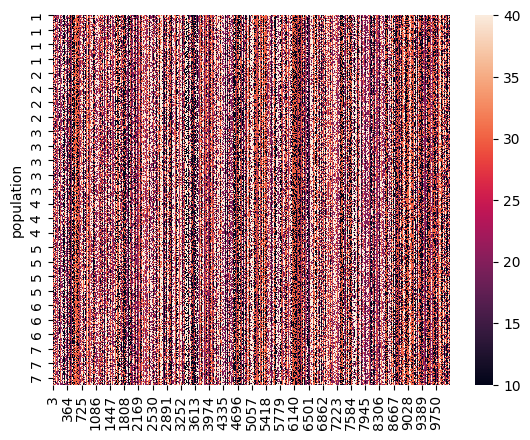

In [ ]:
sns.heatmap(exp)

/usr/local/lib/python3.11/dist-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


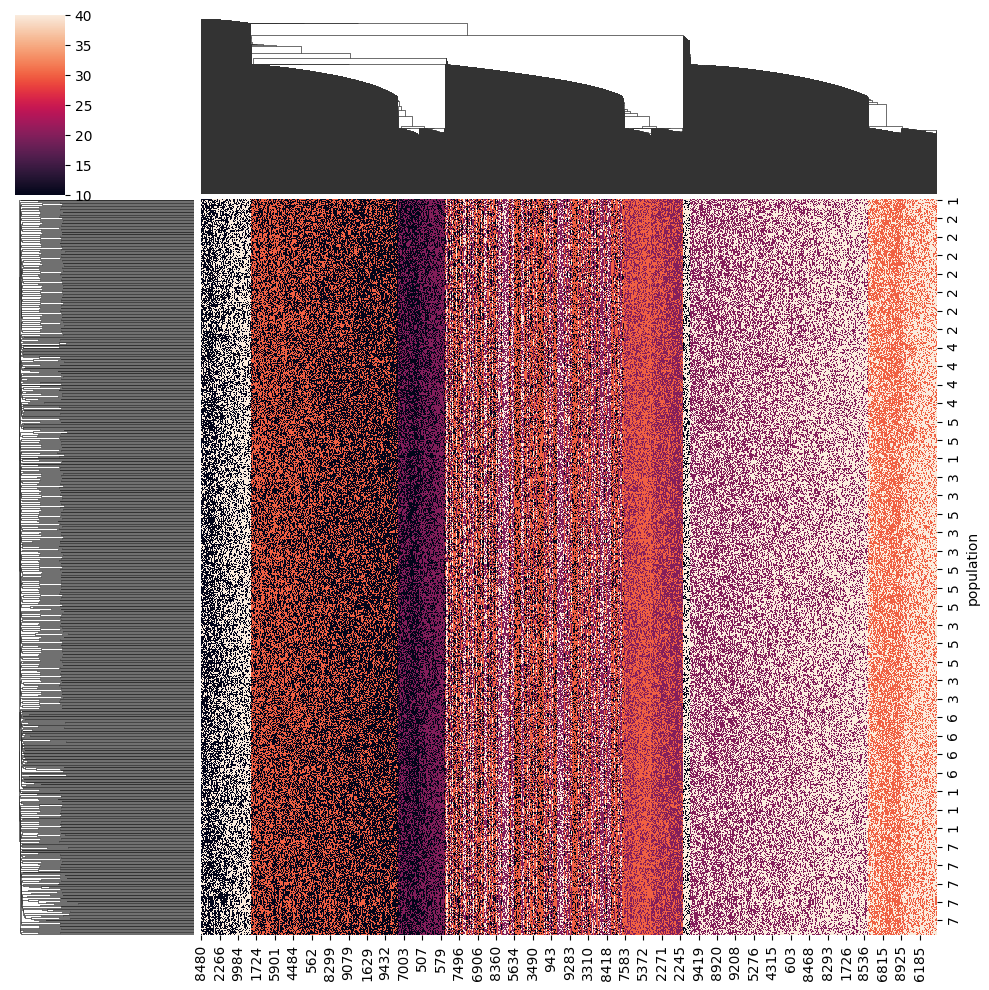

In [ ]:
sns.clustermap(exp)

## PCA


**Primer on PCA**

The idea behind PCA is in essence very simple. For a given set of $m$ vectors of the same size (say $n$), or in other words $m$ $n$-dimensional vectors, we are interested in finding $k$ $n$-dimensional vectors where $k \leq m$ that "best" represent the original $m$ $n$-dimensional vectors.

In other words, when we approximately express each of the $m$ vectors as a linear combination of the $k$ vetcors, then this is the "best" possible representation of teh vectors. These top $k$ "best" vectors are what are called the *principal components of the data*.

In [ ]:
pca = PCA(n_components=3)
pca.fit(table_data)

#Data points projected along the first, second and the third PC
projectedPrincipal = np.matmul(table_data, pca.components_[0])
projectedSecondary = np.matmul(table_data, pca.components_[1])
projectedThird = np.matmul(table_data, pca.components_[2])

# The dimensions of the returned PCA vectors should be the same as that of
# the original data vectors (the rows corresponding to different individuals).

assert(table_data.shape[0] == projectedPrincipal.shape[0])

In [ ]:
table_data.shape


(995, 10101)

In [ ]:
def pca_explained(X, threshold, step):
  if len(threshold) == 0:
    features = step
  else:
    features = X.shape[1]

  for i in range(1, features):
    pca = PCA(n_components = i).fit(X)
    sum_ = pca.explained_variance_ratio_
    # add all components explained variances
    percent = sum(sum_)
    print('{} components at {:.2f}% explained variance'.format(i,percent*100))
    if len(threshold) > 0:
      if percent > threshold: break

pca_explained(table_data, step=10, threshold=[])

1 components at 0.57% explained variance
2 components at 1.03% explained variance
3 components at 1.41% explained variance
4 components at 1.74% explained variance
5 components at 1.99% explained variance
6 components at 2.24% explained variance
7 components at 2.47% explained variance
8 components at 2.70% explained variance
9 components at 2.93% explained variance


In [ ]:
print(pca.explained_variance_)

[13.50110265 11.00085157  8.85879765]


## Population Clusters from Mutations Data

Let's examine the first 2 principal components of X. These components contain lots of information about our data set.  We'll create a scatter plot with each of the 995 rows of $X$ projected onto the first two principal components.  In other words, the horizontal axis is PC1, the vertical axis is PC2, and each individual should be projected onto the subspace spanned by PC1 and PC2.

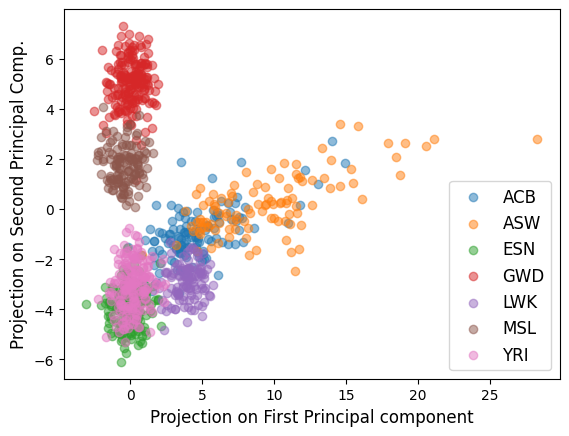

In [ ]:
def groupByPop(x, y, classLabels):

    classDict = {}
    classes = np.unique(classLabels)
    for label in classes:
        idx = np.where(classLabels == label)
        classDict[label] = (x[idx], y[idx])
    for lab in classes:
        x, y = classDict[lab]
        plt.scatter(x, y, label=lab, alpha = 0.5)
    plt.legend(fontsize=12)
    plt.xlabel('Projection on First Principal component', fontsize=12)
    plt.ylabel('Projection on Second Principal Comp.', fontsize=12)
    #plt.savefig('FirstSecond.png', format='png')
    plt.show()

# call the function
groupByPop(projectedPrincipal, projectedSecondary, population)

**Population clustering!** Notice how different population members have similar values of their projections onto the prncipal components. That means, individuals in a particular population have similar gene mutations such that their data vectors start to look similar! So the correlation between the first and second principal components for members of a population helps cluster the groups! So, it is the first and second PCs that capture varibility in genes due to population differences. Let's keep exploring!

## Gender Clusters from Mutations Data

This time, let's examine the first and the third principal components of X. We'll create a scatter plot with each of the 995 rows of $X$ projected onto the first and third principal components this time.

Text(0, 0.5, 'PC2')

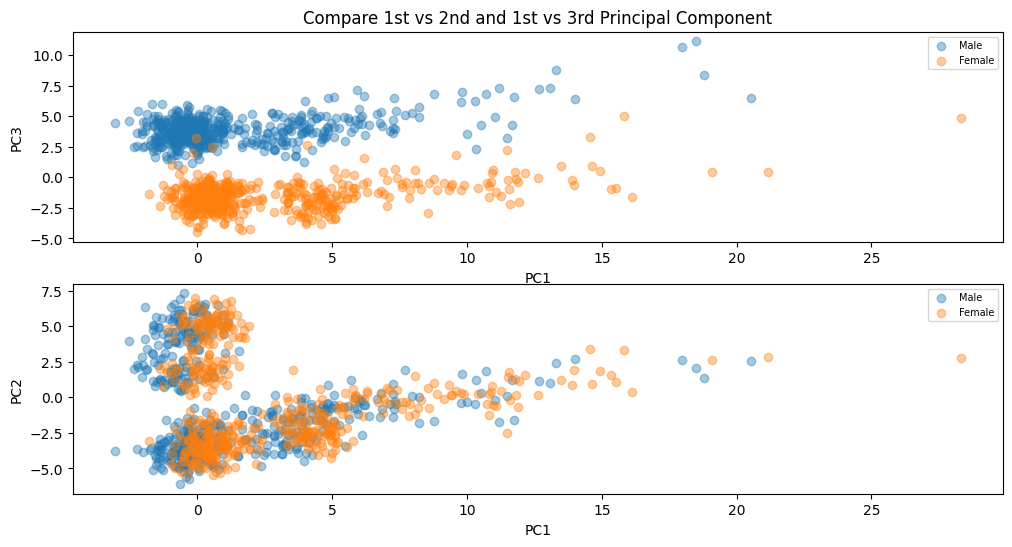

In [ ]:
def groupByGender(x, y, classLabels):

    classDict = {}
    classes = np.unique(classLabels)
    for label in classes:
        idx = np.where(classLabels == label)
        classDict[label] = (x[idx], y[idx])
    for label in classes:
        x, y = classDict[label]
        plt.scatter(x, y, label='Male' if label == 1 else 'Female',alpha=0.4)
    plt.legend(fontsize=7)
    #plt.xlabel('Projection on First Principal component', fontsize=12)
    #plt.ylabel('Projection on Third Principal Comp.', fontsize=12)
    #plt.savefig('FirstThird.png', format='png')
    #plt.show()

# call the function


plt.figure(figsize=(12, 6))
#'Compare 1st vs 2nd and 1st vs 3rd Principal Component')
plt.subplot(2, 1, 1)
groupByGender(projectedPrincipal, projectedThird, gender)
plt.title('Compare 1st vs 2nd and 1st vs 3rd Principal Component')
plt.xlabel('PC1')
plt.ylabel('PC3')

plt.subplot(2, 1, 2)
groupByGender(projectedPrincipal, projectedSecondary, gender)
plt.xlabel('PC1')
plt.ylabel('PC2')



#groupByGender(projectedPrincipal, projectedThird, gender)
#groupByGender(projectedPrincipal, projectedSecondary, gender)


Note that there is a strong correlation between data members within the male and within the female sections. Also note once again, the first and third PC projections tend to be different from each other for males and females allowing for clustering!

## Which chromosomes lead to gender differences?

We just remarked above that the third PC is responsible for popping out the gender differences. But can we say more? Can we say which chromosomes are different between males and females? For answering this, we look at the absolute values of the **third principal component** (not the projections) and create a scatter plot between the Nucleobase index and the corresponding third principal component's absolute value.

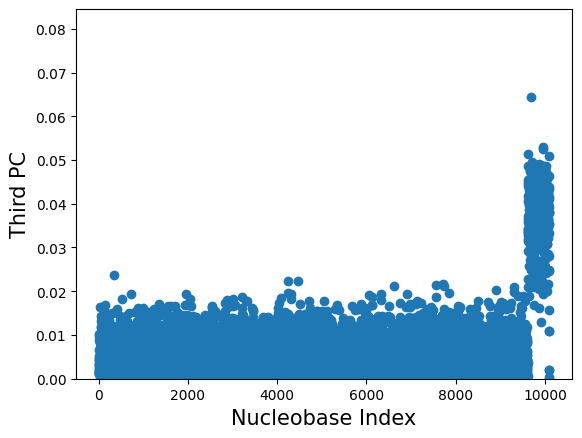

In [ ]:
plt.figure()
plt.scatter(np.arange(1,pca.components_[2].shape[0]+1), np.absolute(pca.components_[2]))
plt.xlabel('Nucleobase Index', fontsize=15)
plt.ylabel('Third PC', fontsize=15)
#plt.savefig('part_f.png', format ='png')
plt.ylim([0, max(np.absolute(pca.components_[2]))+0.02])
plt.show()

We can now say with confidence that the female members and male members must differ in their nucleobases for indices $\sim$9500 and larger. These mutations for index larger than 9500 are responsible then for gender differences.

# ICA

In [ ]:
from sklearn.decomposition import FastICA

In [ ]:

#ica = FastICA(n_components=2, random_state=123, whiten="arbitrary-variance")
ica = FastICA(n_components=2, whiten="arbitrary-variance")

#X_ica = ica.fit(Xmixed).transform(Xmixed)  # Estimate the sources
X_ica = ica.fit_transform(table_data)  # Estimate the sources

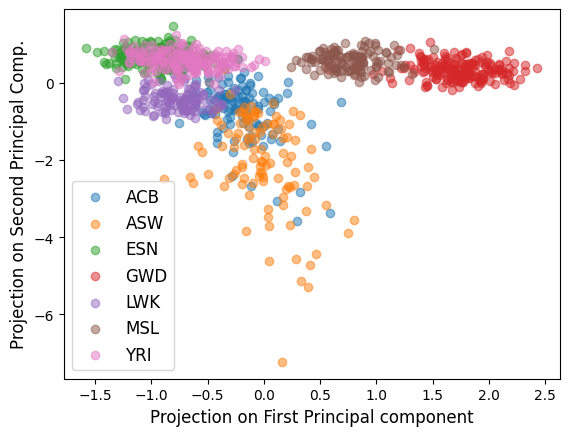

In [ ]:
groupByPop(X_ica[:,0]/np.std(X_ica[:,0]), X_ica[:,1]/np.std(X_ica[:,1]), population)

# t-SNE and MDS

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import MDS

In [ ]:
mds = MDS(n_components = 2)
scaled_data_mds = mds.fit_transform(table_data)

Text(0, 0.5, 'Second Principal Component')

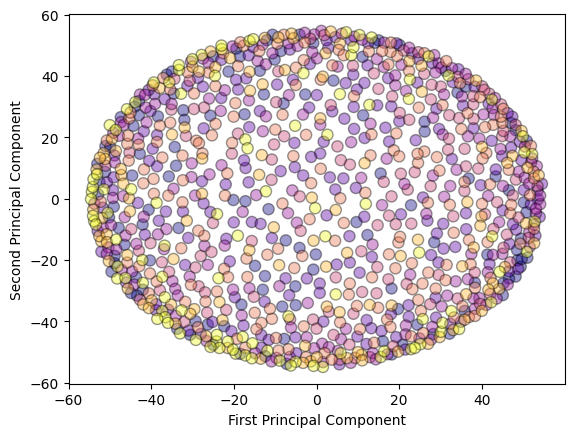

In [ ]:
plt.scatter(scaled_data_mds[:,0], scaled_data_mds[:,1], c=numeric_array , cmap='plasma', alpha=0.4, edgecolors='black', s=65);
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')

Text(0, 0.5, 'Second Principal Component')

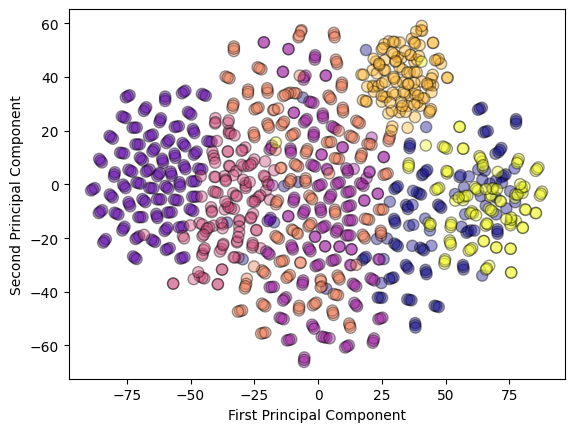

In [ ]:
from sklearn.manifold import TSNE
tsne = TSNE(random_state=0, perplexity=10)
scaled_data_mds_tsne = tsne.fit_transform(table_data)

plt.scatter(scaled_data_mds_tsne[:,0], scaled_data_mds_tsne[:,1], c=numeric_array, cmap='plasma', alpha=0.4, edgecolors='black', s=65);
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')

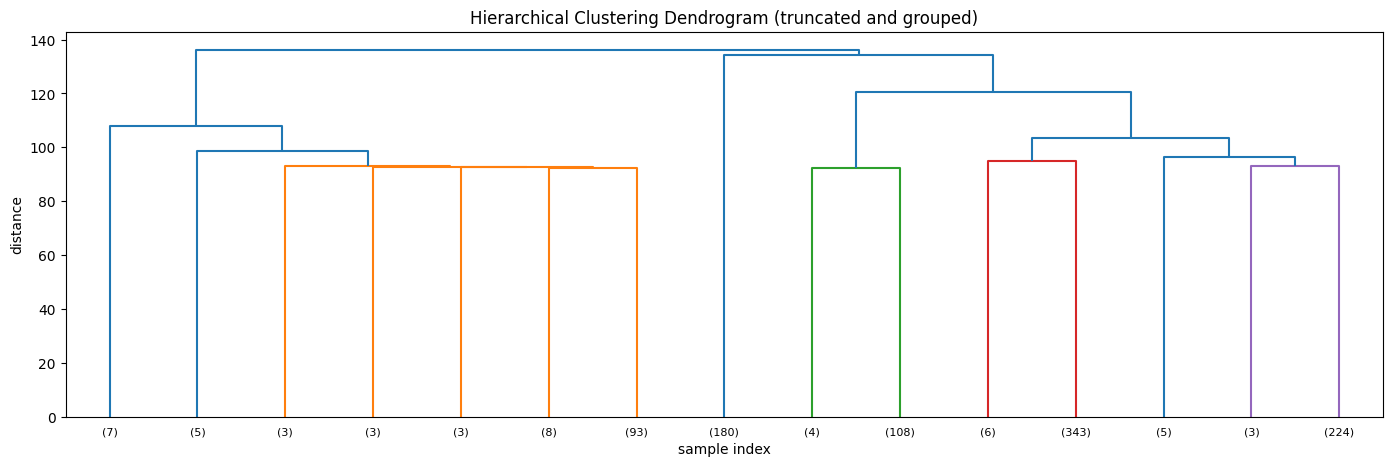

In [ ]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import ward, dendrogram, fcluster


#scaled_data, data_table['Healthy_status'] = make_blobs(random_state = 10)
#n_clusters must be None if distance_threshold is not None
cls = AgglomerativeClustering(n_clusters = 3, metric='euclidean',linkage='ward', distance_threshold=None)
cls_assignment = cls.fit_predict(table_data)


Z = ward(table_data)
plt.figure(figsize=(17,5));
R = dendrogram(Z, truncate_mode='lastp', p=15, orientation='top', leaf_font_size=8)
plt.title('Hierarchical Clustering Dendrogram (truncated and grouped)')
plt.xlabel('sample index')
plt.ylabel('distance')
plt.show()
